<a href="https://colab.research.google.com/github/JoaoAlexandreFerreira/RNA/blob/main/PINN_para_equa%C3%A7%C3%A3o_do_calor_1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Código para testar a rede neural informada pela física para a equação de transferência de calor 1D.

---



A equação da difusão térmica é representada por:

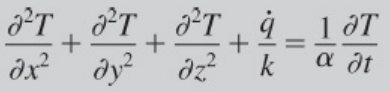

Como queremos estudar o caso 1D da equação, ela pode ser simplificada para:


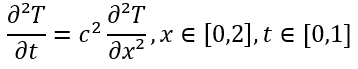


Sendo c² = α = k/(ρcp) que representa a difusividade térmica. Por fim, as condições iniciais e de contorno para esse caso serão, respectivamente:

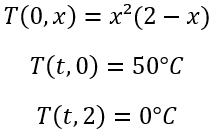

In [70]:
pip install --upgrade pyDOE

In [71]:
import tensorflow as tf
from scipy.io import loadmat
import numpy as np
import keras
import matplotlib.pyplot as plt
import pandas as pd
from keras import Sequential
from keras.layers import Input, Dense
from time import time
from keras.optimizers import Adam
from keras.initializers import Ones, GlorotNormal, he_normal, Zeros
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from pyDOE import lhs
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.optimize

In [72]:
#Agora criando o modelo de Rede neural

def modelopinn(nos, camadas_ocultas):
  modelo = Sequential()
  #Inserindo o numero de variaveis de entrada
  modelo.add(Input(2))
  #Escala de entrada, mapeando os pontos de maximo e minimo
  modelo.add(keras.layers.Lambda(
      lambda x: 2.0*(x - lb)/(ub - lb) - 1.0
  ))
  for i in range(camadas_ocultas):
        modelo.add(Dense(nos, activation='tanh', kernel_initializer=GlorotNormal())) #camada oculta

  modelo.add(Dense(1)) #camada de saída
  modelo.summary()
  return modelo

In [73]:
keras.backend.set_floatx('float32')
tf.random.set_seed(0)
rho = 2699 #Massa específica
k = 226 #Coeficiente de condutividade térmica
cp = 1 #Calor especifico
difus = k/(rho*cp)

#Definindo as condições de contorno e inicial
def inicial(x):
  return (x**2)*(2-x)

def contorno(t, x):
  n = x.shape[0]
  return tf.zeros((n,1))

#Definindo os pontos X
N_0 = 100 #100 pontos para condição inicial
N_b = 100 #100 pontos para condição de contorno
N_r = 10000 #Pontos para a edp

#Pontos do domínio, dado pelo Maziar
tmin = 0. ; tmax = 1.
xmin = 0.; xmax = 2.

#Ponto inferior e superior, respectivamente
lb = tf.constant([tmin, xmin]); ub = tf.constant([tmax, xmax])

#Obtendo pontos para a condição inicial
t0 = tf.zeros((N_0,1))*lb[0]
x0 = tf.random.uniform((N_0,1), lb[1], ub[1]) #Colocando os valores de x0 em ordem aleatoria, indo de -1 a 1
x0 = tf.concat([t0, x0], 1) #Criando uma matriz com os valores de tempo = 0 e de x0

#Valores de u para a condição inicial
u_ini = inicial(x0[:,1:2])

#Repetindo o processo, mas para a condição de contorno
tb = tf.random.uniform((N_b,1), lb[0], ub[0])
xb = lb[1] + (ub[1] - lb[1]) * keras.backend.random_bernoulli((N_b,1), 0.5)
xb = tf.concat([tb, xb], 1)

#Valores na condição de contorno
u_cont = contorno(xb[:,0:1], xb[:,1:2])

#Repetindo o processo, mas agora é para obter os pontos da EDP
tr = tf.random.uniform((N_r,1), lb[0], ub[0])
xr = tf.random.uniform((N_r,1), lb[1], ub[1])
xr = tf.concat([tr, xr], 1)

#Fazendo uma lista, para uso posterior
X_cond = [x0, xb]
u_cond = [u_ini, u_cont]

#Realizando plotagem dos pontos que são usados para condição de contorno, inicial e para edp

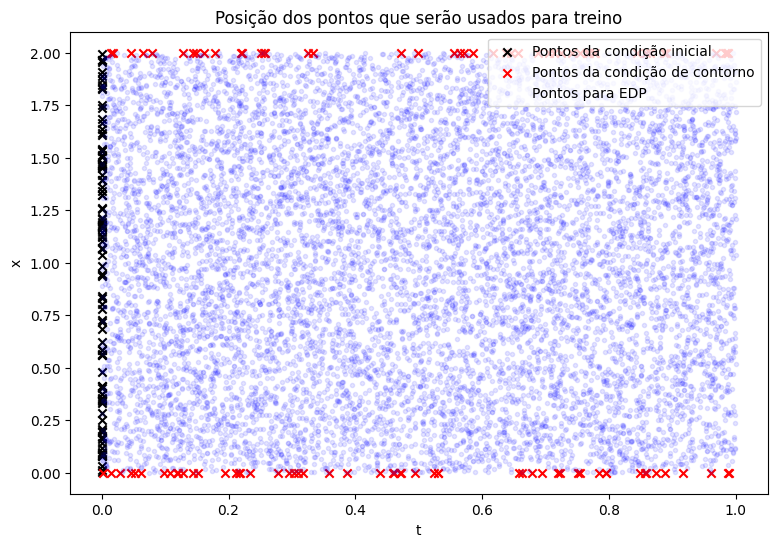

In [74]:
plt.figure(figsize=(9,6))
plt.scatter(x0[:,0:1],x0[:,1:2], c='black', marker ='x')
plt.scatter(xb[:,0:1],xb[:,1:2], c='red', marker ='x')
plt.scatter(xr[:,0:1], xr[:,1:2], c='blue', marker = '.', alpha = 0.1)
plt.xlabel('t'); plt.ylabel('x')
plt.title('Posição dos pontos que serão usados para treino')
plt.legend(['Pontos da condição inicial', 'Pontos da condição de contorno', 'Pontos para EDP'])
plt.show()

In [75]:
#E tirando os gradientes, para calcular a edp
def gradiente(modelo, X_r):
  with tf.GradientTape(persistent=True) as tape:

    #Registrando tempo e posição para a diferenciação automática
    t, x = X_r[:, 0:1], X_r[:,1:2]
    tape.watch(t)
    tape.watch(x)

    #previsão do modelo
    u = modelo(tf.stack([t[:,0], x[:,0]], 1))
    #gradiente du/dx
    ux = tape.gradient(u, x)


    #gradiente du/dt
  ut = tape.gradient(u, t)
  #gradiente du²/d²x
  uxx = tape.gradient(ux, x)

  del tape

  return ut -difus *uxx

def MSE(modelo, xr, X_cond, u_cond):

    #Erro edp
    r = gradiente(modelo, xr)
    erro = tf.reduce_mean(tf.square(r))

    loss = erro

    #Erro da rede neural
    for i in range(len(X_cond)):
        u_pred = modelo(X_cond[i])
        loss += tf.reduce_mean(tf.square(u_cond[i] - u_pred))

    return erro, loss

def grad(modelo, xr, X_cond, u_cond):
  #tirando o gradiente em relação ao modelos, para que eles sejam atualizados posteriormente
  with tf.GradientTape(persistent=True) as tape:
    tape.watch(modelo.trainable_variables)
    erro, loss = MSE(modelo, xr, X_cond, u_cond)

  g = tape.gradient(loss, modelo.trainable_variables)
  del tape

  return erro, loss, g

In [76]:
modelo = modelopinn(20,8) #8 nós com 20 camadas ocultas

otimizador = Adam(learning_rate = 0.001)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_4 (Lambda)           (None, 2)                 0         
                                                                 
 dense_36 (Dense)            (None, 20)                60        
                                                                 
 dense_37 (Dense)            (None, 20)                420       
                                                                 
 dense_38 (Dense)            (None, 20)                420       
                                                                 
 dense_39 (Dense)            (None, 20)                420       
                                                                 
 dense_40 (Dense)            (None, 20)                420       
                                                                 
 dense_41 (Dense)            (None, 20)               

In [77]:
#etapa de treinamento como uma função do TensorFlow para aumentar a velocidade do treinamento
@tf.function
def train_step(modelo):
  #Calculando a perda do modelo em relação ao modelo, com a função grad
  erro, loss, grad_theta = grad(modelo, xr, X_cond, u_cond)

  #Aplicando o gradiente as variaveis do modelo de rede neural
  otimizador.apply_gradients(zip(grad_theta, modelo.trainable_variables))

  return erro, loss

itr = 5000
historico = []
erro_aux = []
t0 = time()

for i in range(itr+1):

    erro, loss = train_step(modelo)

    #Salvando os erros para listar
    historico.append(loss.numpy())
    erro_aux.append(erro.numpy)

    if i%10 == 0:
        print(i,"Loss treino: {:10.8e}, Loss edp: {:10.8e}".format(loss, erro))

print('\nTempo de treino da rede neural: {} segundos'.format(time()-t0))

0 Loss treino: 6.23290539e-01, Loss edp: 4.56277141e-03
10 Loss treino: 3.62205505e-01, Loss edp: 1.84401460e-02
20 Loss treino: 2.89386123e-01, Loss edp: 1.57178827e-02
30 Loss treino: 2.19391942e-01, Loss edp: 3.77923995e-02
40 Loss treino: 1.94546252e-01, Loss edp: 5.54697402e-02
50 Loss treino: 1.75005734e-01, Loss edp: 4.33919691e-02
60 Loss treino: 1.50474057e-01, Loss edp: 4.36322764e-02
70 Loss treino: 1.25933886e-01, Loss edp: 3.65382358e-02
80 Loss treino: 9.80096459e-02, Loss edp: 3.76236886e-02
90 Loss treino: 6.80297166e-02, Loss edp: 3.00120637e-02
100 Loss treino: 4.03521396e-02, Loss edp: 2.06244476e-02
110 Loss treino: 2.05875374e-02, Loss edp: 1.14819659e-02
120 Loss treino: 9.95287113e-03, Loss edp: 6.16327673e-03
130 Loss treino: 5.13895415e-03, Loss edp: 3.30006331e-03
140 Loss treino: 2.94680544e-03, Loss edp: 1.80120429e-03
150 Loss treino: 1.93685037e-03, Loss edp: 1.08663901e-03
160 Loss treino: 1.48951216e-03, Loss edp: 7.90722785e-04
170 Loss treino: 1.273812

In [78]:
N = 600
tspace = np.linspace(lb[0], ub[0], N + 1)
xspace = np.linspace(lb[1], ub[1], N + 1)
T, X = np.meshgrid(tspace, xspace)
Xgrid = np.vstack([T.flatten(),X.flatten()]).T

#Realizando predição
upred = modelo(Xgrid)

U = upred.numpy().reshape(N+1,N+1)

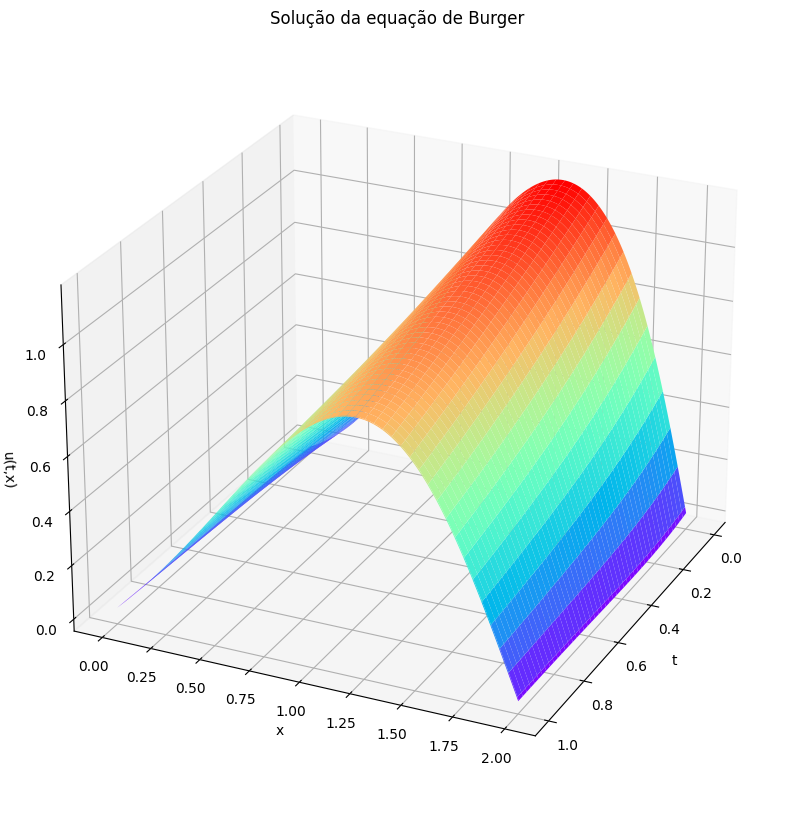

In [79]:
fig = plt.figure(figsize=(10,12))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(T, X, U, cmap='rainbow');
ax.view_init(25,25)
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_zlabel('u(t,x)')
ax.set_title('Solução da equação de Burger');
plt.show()

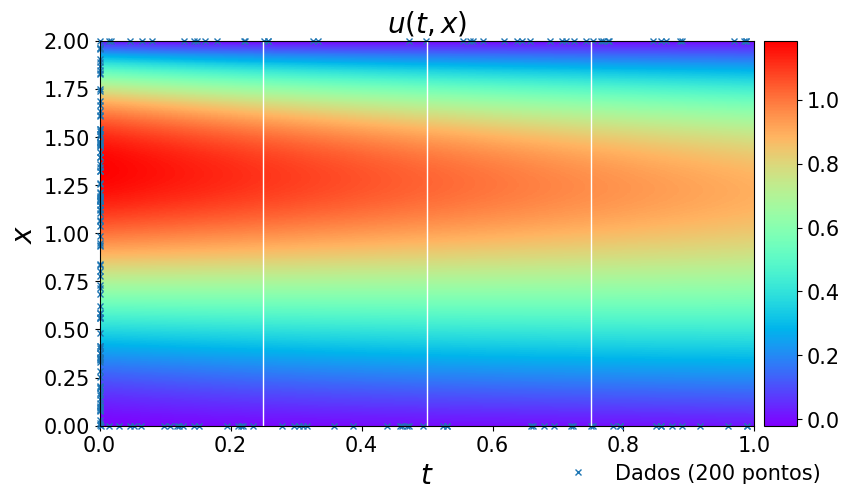

In [80]:
X_aux = np.vstack([x0,xb])
u_aux = np.vstack([u_ini,u_cont])
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

h = ax.imshow(U, interpolation='nearest', cmap='rainbow',
              extent=[tmin, tmax, xmin, xmax],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15)

ax.plot(
    X_aux[:,0],
    X_aux[:,1],
    'x', label = 'Dados (%d pontos)' % (u_aux.shape[0]),
    markersize = 4,
    clip_on = False,
    alpha=1.0
)

line = np.linspace(xmin, xmax, 2)[:,None]
ax.plot(tspace[150]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(tspace[300]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(tspace[450]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
ax.legend(
    loc='upper center',
    bbox_to_anchor=(0.9, -0.05),
    ncol=5,
    frameon=False,
    prop={'size': 15}
)
ax.set_title('$u(t,x)$', fontsize = 20)
ax.tick_params(labelsize=15)

plt.show()

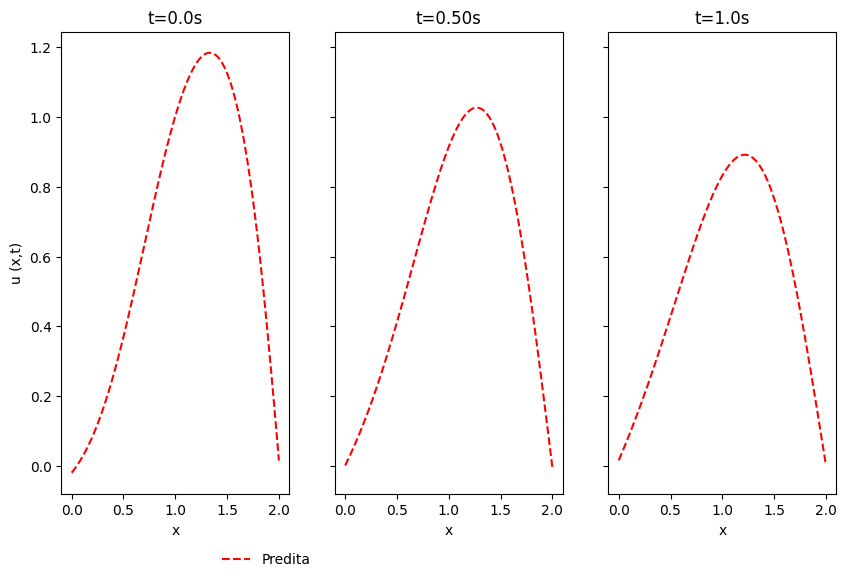

In [81]:
N = 600
xspace = np.linspace(lb[1], ub[1], N + 1)

t_ini = np.zeros((N+1))
T, X = np.meshgrid(t_ini, xspace)
X0 = np.vstack([T.flatten(),X.flatten()]).T

t_050 = np.ones((N+1))*0.50
T, X = np.meshgrid(t_050, xspace)
X050 = np.vstack([T.flatten(),X.flatten()]).T

t_1 = np.ones((N+1))*1
T, X = np.meshgrid(t_1, xspace)
X1 = np.vstack([T.flatten(),X.flatten()]).T

t_15 = np.ones((N+1))*1.5
T, X = np.meshgrid(t_15, xspace)
X15 = np.vstack([T.flatten(),X.flatten()]).T

t_2 = np.ones((N+1))*1.5
T, X = np.meshgrid(t_2, xspace)
X2 = np.vstack([T.flatten(),X.flatten()]).T

fig, axs = plt.subplots(1, 3, figsize=(10,6) ,sharey=True)


axs[0].plot(X0[:,1], modelo(X0).numpy(), linestyle ='dashed', color='r', label = 'Predita')
axs[0].set_title('t=0.0s')
axs[0].set_xlabel('x')
axs[0].set_ylabel('u (x,t)')

axs[1].plot(X050[:,1], modelo(X050).numpy(),linestyle='dashed', color='r', label = 'Predita')
axs[1].set_title('t=0.50s')
axs[1].set_xlabel('x')


axs[2].plot(X1[:,1], modelo(X1).numpy(), linestyle='dashed',color='r', label = 'Predita')
axs[2].set_title('t=1.0s')
axs[2].set_xlabel('x')


plt.legend(
    loc='upper center',
    bbox_to_anchor=(-1.5, -0.10),
    ncol=5,
    frameon=False
)
plt.show()